# Test notebook for boosting

The goal of this notebook is to test the algorithms on ```boosting.py```. We will teste them on four datasets:

- Diabetes dataset
- Prostate Cancer dataset
- California Housing Dataset
- Leukemia Dataset

We first import usefull libraries and define usefull functions:

In [ ]:
import numpy as np
import pandas as pd
from boosting import Boosting
from sklearn.linear_model import LinearRegression


def normalize_data(data,responses):
    y = responses - np.mean(responses)
    X = data - np.mean(data, axis=0)
    X = X / np.linalg.norm(X, axis=0)
    return X, y


def r_squared(X,y):
    reg = LinearRegression().fit(X, y)
    r2 = reg.score(X, y)
    return r2

def r2andmse(X,b,y):
    predictions = np.dot(X, b)
    ss_res = np.sum((predictions - y)**2)
    ss_tot = np.sum((y - np.mean(y))**2)
    r_squared = 1 - (ss_res / ss_tot)
    mse = np.mean((y - predictions) ** 2)
    return (r_squared, mse)

r2values = {}


def test_boosting(X,y,nameofexperiment
                  ,num_itr = 10000, 
                  epsilon1 = 0.1, epsilon2 = 0.25, epsilon3 = 0.01, epsilon4 = 0.1
                  ,delta = 10079, 
                  num_itr2 = 50000, start = 1, end = 10000):
    """
    Test various boosting algorithms on the given dataset.
    Parameters:
        X : numpy.ndarray
        y : numpy.ndarray   
        nameofexperiment : str
            Name of the experiment for logging purposes.
        num_itr : int
            Number of iterations for the boosting algorithms not the Path-R-FS.
        epsilon1 : float
            Learning rate for LS-Boost.
        epsilon2 : float
            Learning rate for FS-Boost and R-FS-Boost.  
        epsilon3 : float
            Learning rate for Path-R-FS-Boost.
        epsilon4 : float
            Learning rate for Path-R-FS-Boost.
        delta : float
            Regularization parameter for R-FS-Boost.
        num_itr2 : int
            Number of iterations for Path-R-FS-Boost.
        start : float
            Start value for delta list in Path-R-FS-Boost. 
        end : float
            End value for delta list in Path-R-FS-Boost.
    Returns:
        dict: A dictionary with R-squared and MSE for each boosting algorithm.
    """

    X_norm, y_norm = normalize_data(X,y)

    sklearn_r2_first = r_squared(X_norm, y_norm)
    r2values[nameofexperiment] = sklearn_r2_first
    
    exp = Boosting(X_norm, y_norm)
    boostingdict = {}

    b_ls = exp.LS_Boost(numiter=num_itr, epsilon=epsilon1)
    boostingdict['LS-Boost'] = r2andmse(X_norm, b_ls, y_norm)

    b_fs = exp.FS_Boost(numiter=num_itr, epsilon=epsilon2)
    boostingdict['FS-Boost'] = r2andmse(X_norm, b_fs, y_norm)

    b_rfs = exp.R_FS(numiter=num_itr, epsilon=epsilon3, delta=delta)
    boostingdict['R-FS-Boost'] = r2andmse(X_norm, b_rfs, y_norm)

    num_itr = num_itr2
    deltalist = list(np.linspace(start, end, num_itr2+1))
    b_pathrfs = exp.Path_R_FS(numiter=num_itr2, epsilon=epsilon4, delta_list=deltalist)
    boostingdict['Path-R-FS-Boost'] = r2andmse(X_norm, b_pathrfs, y_norm)

    return boostingdict

## Diabetes Dataset

We can import this dataset:

In [2]:
from sklearn.datasets import load_diabetes

data = load_diabetes().data
response = load_diabetes().target

In [3]:
data.shape, response.shape

((442, 10), (442,))

We have n = 442 and p = 10. Next we will:

-  normalice our data and our responses
- Create a benchmark with ```Sklearn```
- Do our experiments

Using the function: ```test_boosting```


In [4]:
bosting_first = test_boosting(data, response, 'Diabetes Dataset First Experiment')

In [5]:
r2values

{'Diabetes Dataset First Experiment': 0.5177484222203499}

## Prostate Cancer

We import ourdataset:

In [7]:
url = "https://web.stanford.edu/~hastie/ElemStatLearn/datasets/prostate.data"
df = pd.read_csv(url, sep="\t")
X = df.drop(columns=["lpsa", "train","Unnamed: 0"]).values
y = df["lpsa"].values

The same pipeline as before:

In [8]:
boosting_second = test_boosting(X, y, 'Prostate Dataset Second Experiment')

## California Housing 



Its already only a pipeline:

In [11]:
from sklearn.datasets import fetch_california_housing
data = fetch_california_housing()
X, y = data.data, data.target
boosting_third = test_boosting(X, y, 'California Housing Dataset Third Experiment')

## Leukemia Dataset

In [12]:
from sklearn.datasets import fetch_openml
data = fetch_openml(name="leukemia", version=1, as_frame=False)
X, y_str = data.data, data.target
y = np.where(y_str == 'ALL', 0, 1).astype(float)

boosting_fourth = test_boosting(X, y, 'Leukemia Dataset Fourth Experiment')

c:\Users\juann\anaconda3\Lib\site-packages\sklearn\datasets\_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


## Evaluation and conclution


We will evaluate the results of our experiments. First we will do a plot:

- x axis: Algo
- y axis: r^2 value

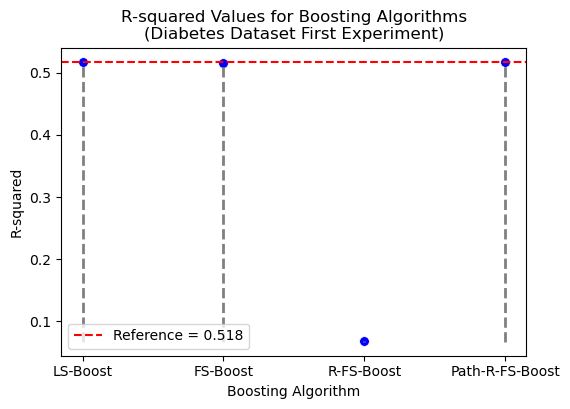

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.DataFrame({"Algo": list(bosting_first.keys()),
                   "R_squared_first": [val[0] for val in bosting_first.values()],
                   "R_squared_second": [val[0] for val in boosting_second.values()],
                   "R_squared_third": [val[0] for val in boosting_third.values()],
                   "R_squared_fourth": [val[0] for val in boosting_fourth.values()]})

plt.figure(figsize=(6,4))

sns.scatterplot(data=df, x="Algo", y="R_squared_first", s=50, 
                marker ='o', color='blue', legend=False)

plt.axhline(r2values["Diabetes Dataset First Experiment"], color='red', 
            linestyle='--', 
            label=f'Reference = {r2values["Diabetes Dataset First Experiment"]:.3f}')
plt.vlines(x=df["Algo"], ymin=min(df['R_squared_first']) - 0.001, 
           ymax=df['R_squared_first'], color='gray', linestyle='--', lw=2)


plt.title("R-squared Values for Boosting Algorithms\n(Diabetes Dataset First Experiment)")
plt.ylabel("R-squared")
plt.xlabel("Boosting Algorithm")
plt.legend()
plt.ylim=(0,1.05)
plt.show()  

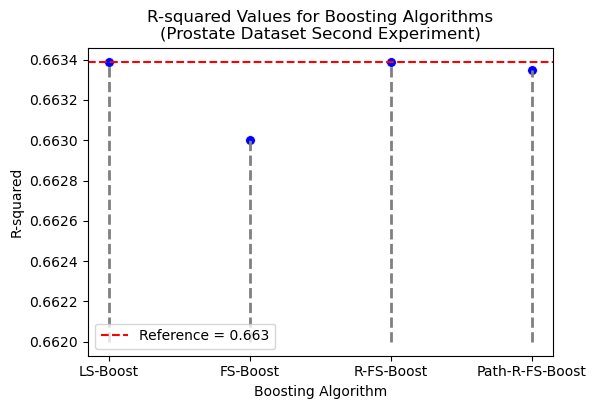

In [14]:
plt.figure(figsize=(6,4))

sns.scatterplot(data=df, x="Algo", y="R_squared_second", s=50, 
                marker ='o', color='blue', legend=False)

plt.axhline(r2values["Prostate Dataset Second Experiment"], color='red', 
            linestyle='--', 
            label=f'Reference = {r2values["Prostate Dataset Second Experiment"]:.3f}')
plt.vlines(x=df["Algo"], ymin=min(df['R_squared_second']) - 0.001, 
           ymax=df['R_squared_second'], color='gray', linestyle='--', lw=2)


plt.title("R-squared Values for Boosting Algorithms\n(Prostate Dataset Second Experiment)")
plt.ylabel("R-squared")
plt.xlabel("Boosting Algorithm")
plt.legend()
plt.ylim=(0,1.05)
plt.show()  

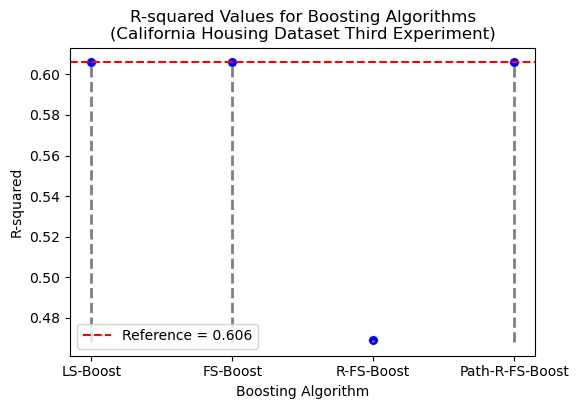

In [15]:
plt.figure(figsize=(6,4))

sns.scatterplot(data=df, x="Algo", y="R_squared_third", s=50, 
                marker ='o', color='blue', legend=False)

plt.axhline(r2values["California Housing Dataset Third Experiment"], color='red', 
            linestyle='--', 
            label=f'Reference = {r2values["California Housing Dataset Third Experiment"]:.3f}')
plt.vlines(x=df["Algo"], ymin=min(df['R_squared_third']) - 0.001, 
           ymax=df['R_squared_third'], color='gray', linestyle='--', lw=2)


plt.title("R-squared Values for Boosting Algorithms\n(California Housing Dataset Third Experiment)")
plt.ylabel("R-squared")
plt.xlabel("Boosting Algorithm")
plt.legend()
plt.ylim=(0,1.05)
plt.show()  

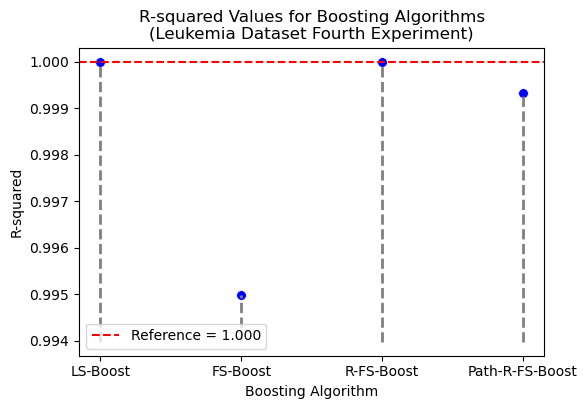

In [16]:
plt.figure(figsize=(6,4))

sns.scatterplot(data=df, x="Algo", y="R_squared_fourth", s=50, 
                marker ='o', color='blue', legend=False)

plt.axhline(r2values["Leukemia Dataset Fourth Experiment"], color='red', 
            linestyle='--', 
            label=f'Reference = {r2values["Leukemia Dataset Fourth Experiment"]:.3f}')
plt.vlines(x=df["Algo"], ymin=min(df['R_squared_fourth']) - 0.001, 
           ymax=df['R_squared_fourth'], color='gray', linestyle='--', lw=2)


plt.title("R-squared Values for Boosting Algorithms\n(Leukemia Dataset Fourth Experiment)")
plt.ylabel("R-squared")
plt.xlabel("Boosting Algorithm")
plt.legend()
plt.ylim=(0,1.05)
plt.show()  

Now we will evaluate the difference of each of our algorithms with the defined benchmark:

In [17]:
df_1 = pd.DataFrame({"Experiment": list(r2values.keys()),
                     "Diference":
                     [max([abs(r2values["Diabetes Dataset First Experiment"]-val[0]) 
                           for val in bosting_first.values()]),
                      max([abs(r2values["Prostate Dataset Second Experiment"]-val[0]) 
                           for val in boosting_second.values()]),  
                      max([abs(r2values["California Housing Dataset Third Experiment"]-val[0]) 
                           for val in boosting_third.values()]),
                      max([abs(r2values["Leukemia Dataset Fourth Experiment"]-val[0]) 
                           for val in boosting_fourth.values()])],
                     "Algo": 
                      [
                       list(bosting_first.keys())[np.argmax([abs(r2values["Diabetes Dataset First Experiment"]-val[0]) 
                                                             for val in bosting_first.values()])] ,
                       list(boosting_second.keys())[np.argmax([abs(r2values["Prostate Dataset Second Experiment"]-val[0])  
                                                             for val in boosting_second.values()])],
                       list(boosting_third.keys())[np.argmax([abs(r2values["California Housing Dataset Third Experiment"]-val[0])  
                                                             for val in boosting_third.values()])], 
                       list(boosting_fourth.keys())[np.argmax([abs(r2values["Leukemia Dataset Fourth Experiment"]-val[0])  
                                                             for val in boosting_fourth.values()])] 
                    ]
                    })

In [18]:
df_1

,Experiment,Diference,Algo
0,Diabetes Dataset First Experiment,0.449272,R-FS-Boost
1,Prostate Dataset Second Experiment,0.000389,FS-Boost
2,California Housing Dataset Third Experiment,0.136946,R-FS-Boost
3,Leukemia Dataset Fourth Experiment,0.005023,FS-Boost


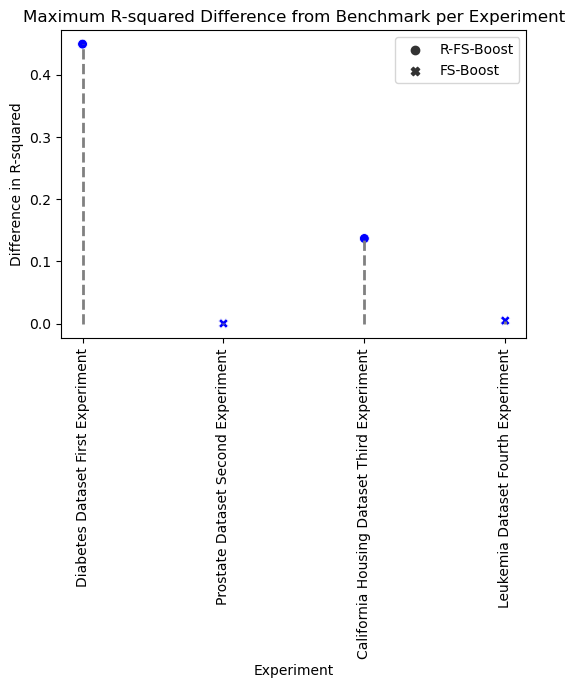

In [19]:
plt.figure(figsize=(6,4))

sns.scatterplot(data=df_1, x="Experiment", y="Diference",style="Algo", s=50, 
                marker ='o', color='blue', legend=True)

plt.vlines(x=df_1["Experiment"], ymin=min(df_1['Diference']) - 0.001, 
           ymax=df_1['Diference'], color='gray', linestyle='--', lw=2)


plt.title("Maximum R-squared Difference from Benchmark per Experiment")
plt.ylabel("Difference in R-squared")
plt.xlabel("Experiment")
plt.xticks(rotation=90)
plt.legend()
plt.ylim=(0,1.05)
plt.show()  

We can see then that the differences are relatively low, not exceeding values of $7$%, although this value occurred in a dataset with $20640$ observations and only $9$ features, which is expected due to the ill-conditioning of the matrix. In general, we can conclude that the errors of our algorithms are less than $2$%.